In [1]:
from typing import List
from scipy.stats import sem 
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from torch.optim import Adam

from utils import conjugate_gradient, train, bootstrap, normalize, bicg

# Build the environment
from utils.trainer import Rollout

from IPython.display import HTML
from base64 import b64encode
import imageio

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [2]:
env = gym.make('LunarLander-v2')
obs_shape = env.observation_space.shape
num_actions = env.action_space.n

In [3]:
print("State shape:{}, \n State:{}".format(obs_shape, env.reset()))
print("Number of actions:", num_actions)
print("Sample action:", env.action_space.sample())

State shape:(8,), 
 State:(array([-0.00214844,  1.416448  , -0.21762481,  0.24568291,  0.00249624,
        0.04929524,  0.        ,  0.        ], dtype=float32), {})
Number of actions: 4
Sample action: 2


In [4]:
# Close any existing env and create a new one with render_mode='rgb_array'
env.close()
env = gym.make("LunarLander-v2", render_mode="rgb_array")

frames = []
env.reset()
for _ in range(100):
    frame = env.render()
    frames.append(frame)
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("Episode terminated after {} timesteps".format(_))
        break
    
env.close()
print("Number of frames:", len(frames)) 
imageio.mimsave('./LunarLander-v2.mp4', frames, fps=30)
show_video('./LunarLander-v2.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode terminated after 82 timesteps
Number of frames: 83


In [5]:
import torch.nn.functional as F


actor_hidden = 32
class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

actor = Actor(input_size=obs_shape[0], hidden_size=actor_hidden, output_size=num_actions)

# Critic takes a state and returns its values
critic_hidden = 32
# critic = nn.Sequential(nn.Linear(obs_shape[0], critic_hidden),
#                        nn.ReLU(),
#                        nn.Linear(critic_hidden, 1))

class LargeCritic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LargeCritic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2 * hidden_size)
        self.fc3 = nn.Linear(2 * hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        value = self.fc4(x)
        return value
    
critic = LargeCritic(input_size=obs_shape[0], hidden_size=critic_hidden, output_size=1)

critic_optimizer = Adam(critic.parameters(), lr=0.005)

c:\Users\Amirreza\.conda\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Test the networks
state = torch.tensor(env.reset()[0], dtype=torch.float32)
print("State:", state)
print("Actor:", actor(state))
print("Critic:", critic(state))

State: tensor([-0.0030,  1.4019, -0.3064, -0.4003,  0.0035,  0.0694,  0.0000,  0.0000])
Actor: tensor([0.2236, 0.2622, 0.1890, 0.3252], grad_fn=<SoftmaxBackward0>)
Critic: tensor([-0.1649], grad_fn=<ViewBackward0>)


In [7]:
# Critic will be updated to give more accurate advantages
def update_critic(advantages):
    loss = .5 * (advantages ** 2).mean()  # MSE
    critic_optimizer.zero_grad()
    loss.backward()
    critic_optimizer.step()
    
def get_action(state: List[float]) -> int:
    # Turn it into a batch with a single element
    state = state if isinstance(state, torch.Tensor) else torch.tensor(state)
    state = state.float().unsqueeze(0)
    probs = actor(state)
    if torch.any(torch.isnan(probs)):
        for p in actor.parameters():
            print(p)
    action = Categorical(probs=probs).sample()
    return action.item()

In [8]:
# Test the get_action function
# state = env.reset()[0]
print("State:", state)
print("Action:", get_action(state))

State: tensor([-0.0030,  1.4019, -0.3064, -0.4003,  0.0035,  0.0694,  0.0000,  0.0000])
Action: 3


In [9]:
def estimate_advantages(states, last_state, rewards):
    values = critic(states)
    last_value = critic(last_state.unsqueeze(0))
    next_values = bootstrap(rewards, last_value, discounting=0.99)
    advantages = next_values - values
    return advantages


def flat_grad(y, x, retain_graph=False, create_graph=False):
    if create_graph:
        retain_graph = True

    g = torch.autograd.grad(
        y, x, retain_graph=retain_graph, create_graph=create_graph)
    g = torch.cat([t.view(-1) for t in g])
    return g


def HVP(df, v, x):
    return flat_grad(df @ v, x, retain_graph=True)


delta = 0.01
iterations = 10

In [10]:
def line_search(step, criterion, alpha=0.9, max_iterations=10):
    i = 0
    while not criterion((alpha ** i) * step)[0] and i < max_iterations:
        i += 1
        # if i == max_iterations:
        #     print("Max iterations reached")
    
    return criterion((alpha ** i) * step)[1:]


def apply_update(grad_flattened):
    n = 0
    for p in actor.parameters():
        numel = p.numel()
        g = grad_flattened[n:n + numel].view(p.shape)
        p.data += g
        n += numel


def surrogate_loss(new_probabilities, old_probabilities, advantages):
    return (new_probabilities / old_probabilities * advantages).mean()


def kl_div(p, q):
    p = p.detach()
    return (p * (p.log() - q.log())).sum(-1).mean()

# def JS_divergence(p, q):
#     return 0.5 * (kl_div(p, q) + kl_div(q, p))

In [11]:
# Our main training function
def update_agent(rollouts: List[Rollout]) -> None:
    states = torch.cat([r.states for r in rollouts], dim=0)
    actions = torch.cat([r.actions for r in rollouts], dim=0).flatten()

    advantages = [estimate_advantages(
        states, next_states[-1], rewards) for states, _, rewards, next_states in rollouts]
    advantages = normalize(torch.cat(advantages, dim=0).flatten())

    update_critic(advantages)

    distribution = actor(states)
    distribution = torch.distributions.utils.clamp_probs(distribution)
    probabilities = distribution[range(distribution.shape[0]), actions]

    # Now we have all the data we need for the algorithm

    # We will calculate the gradient wrt to the new probabilities (surrogate function),
    # so second probabilities should be treated as a constant
    L = surrogate_loss(probabilities, probabilities.detach(), advantages)
    KL = kl_div(distribution, distribution)

    # print(KL)

    inputs = list(actor.parameters())

    g = flat_grad(L, actor.parameters(), retain_graph=True)
    # Create graph, because we will call backward() on it (for HVP)
    d_kl = flat_grad(KL, inputs, create_graph=True)


    def HVP(v):
        return flat_grad(d_kl @ v, inputs, retain_graph=True)
    
    # def HVP_T(v):
    #     return flat_grad(v.T @d_kl, inputs, retain_graph=True).T
    
    # search_dir = conjugate_gradient(HVP, g, max_iterations=iterations, print_iterations=True)
    search_dir = conjugate_gradient(HVP, g, max_iterations=10)
    # search_dir = bicg(HVP, HVP_T, g, max_iterations=iterations)
    max_length = torch.sqrt(2 * delta / (search_dir @ HVP(search_dir)))
    max_step = max_length * search_dir

    def criterion(step):
        apply_update(step)

        with torch.no_grad():
            distribution_new = actor(states)
            distribution_new = torch.distributions.utils.clamp_probs(
                distribution_new)
            probabilities_new = distribution_new[range(
                distribution_new.shape[0]), actions]

            L_new = surrogate_loss(
                probabilities_new, probabilities, advantages)
            KL_new = kl_div(distribution, distribution_new)

        L_improvement = L_new - L

        if L_improvement.item() > 0 and KL_new.item() <= delta:
            return True, KL_new.item(), L_improvement.item()
        
        apply_update(-step)
        return False, KL_new.item(), L_improvement.item()

    # KL_diff = line_search(max_step, criterion, max_iterations=10)
    KL_diff, L_improvement = line_search(max_step, criterion, max_iterations=10)
    return KL_diff, L_improvement
    


In [12]:
# Initialize the Actor and Critic networks to random weights
actor.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
critic.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
KL_history, surrogate_loss_history, rewards_all = train(env, get_action, update_agent, num_trajectories=10, render_frequency=None, print_frequency=1, plot_frequency=None, epochs=40)

Epoch	0 	| 0.48s 	| Mean total reward	-256.5418
Epoch	1 	| 0.88s 	| Mean total reward	-158.8126
Epoch	2 	| 1.35s 	| Mean total reward	-211.6131
Epoch	3 	| 1.81s 	| Mean total reward	-126.5666
Epoch	4 	| 2.25s 	| Mean total reward	-140.7570
Epoch	5 	| 2.72s 	| Mean total reward	-132.0778
Epoch	6 	| 3.14s 	| Mean total reward	-128.3675
Epoch	7 	| 3.60s 	| Mean total reward	-178.2863
Epoch	8 	| 4.01s 	| Mean total reward	-116.0202
Epoch	9 	| 4.44s 	| Mean total reward	-212.8206
Epoch	10 	| 4.86s 	| Mean total reward	-142.2647
Epoch	11 	| 5.27s 	| Mean total reward	-129.0785
Epoch	12 	| 5.73s 	| Mean total reward	-123.1513
Epoch	13 	| 6.18s 	| Mean total reward	-112.9300
Epoch	14 	| 6.62s 	| Mean total reward	-95.4662
Epoch	15 	| 6.98s 	| Mean total reward	-68.5926
Epoch	16 	| 7.41s 	| Mean total reward	-100.1867
Epoch	17 	| 7.85s 	| Mean total reward	-85.3209
Epoch	18 	| 8.25s 	| Mean total reward	-95.2592
Epoch	19 	| 8.64s 	| Mean total reward	-79.3322
Epoch	20 	| 9.09s 	| Mean total rew

In [22]:
# Create a new environment with render mode for video
env_video = gym.make("LunarLander-v2", render_mode="rgb_array")

num_epochs = 100
delta = 0.003
iterations = 10

actor.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
critic.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

# Train the agent using the best hyperparameters (but for fewer epochs to save time)
print("Training best policy...")
KL_history, surrogate_loss_history, rewards_history = train(
    env, get_action, update_agent, num_trajectories=10, 
    render_frequency=None, print_frequency=10, plot_frequency=None, epochs=num_epochs)

# Now record a video of the policy in action
print("Recording video of trained policy...")
frames = []
obs, info = env_video.reset()
done = False
total_reward = 0

# Run for up to 1000 steps to ensure we capture a complete episode
for _ in range(1000):
    frames.append(env_video.render())
    action = get_action(obs)
    obs, reward, terminated, truncated, info = env_video.step(action)
    total_reward += reward
    if terminated or truncated:
        print(f"Episode ended with total reward: {total_reward:.2f}")
        break

env_video.close()

print("Total reward:", total_reward)
# Save the video
video_path = './LunarLander_trained_policy.mp4'
imageio.mimsave(video_path, frames, fps=30)
print(f"Video saved to {video_path}")

# Display the video
show_video(video_path)

Training best policy...
Epoch	9 	| 3.84s 	| Mean total reward	-118.5256
Epoch	19 	| 7.91s 	| Mean total reward	-102.5634
Epoch	29 	| 12.12s 	| Mean total reward	-91.0689
Epoch	39 	| 17.33s 	| Mean total reward	-54.8399
Epoch	49 	| 28.18s 	| Mean total reward	-91.8409
Epoch	59 	| 69.44s 	| Mean total reward	-133.3000
Epoch	69 	| 166.77s 	| Mean total reward	-56.6395
Epoch	79 	| 285.75s 	| Mean total reward	-36.4498
Epoch	89 	| 412.85s 	| Mean total reward	-21.5711
Epoch	99 	| 541.06s 	| Mean total reward	-16.6494
Recording video of trained policy...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode ended with total reward: -0.58
Total reward: -0.5838024637717769
Video saved to ./LunarLander_trained_policy.mp4


In [24]:
kl_all = []
surrogate_loss_all = []
rewards_all = []

num_runs = 20
num_epochs = 100
delta = 0.005
iterations = 100

for run in range(num_runs):
    if run % 5 == 0:
        print(f"Starting run {run + 1}/{num_runs}")
    # Reset actor and critic networks to random weights
    actor.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    critic.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    
    # Train the agent and obtain histories
    KL_history, surrogate_loss_history, rewards_history = train(
        env, get_action, update_agent, num_trajectories=20, 
        render_frequency=None, print_frequency=40, plot_frequency=None, epochs=num_epochs)
    
    kl_all.append(KL_history)
    surrogate_loss_all.append(surrogate_loss_history)
    rewards_all.append(rewards_history)
    
print("All runs completed!")

Starting run 1/20
Epoch	39 	| 37.20s 	| Mean total reward	-121.7103
Epoch	79 	| 189.72s 	| Mean total reward	47.0252
Epoch	39 	| 31.64s 	| Mean total reward	-104.1734
Epoch	79 	| 240.62s 	| Mean total reward	-29.9860
Epoch	39 	| 36.20s 	| Mean total reward	-93.6001
Epoch	79 	| 289.93s 	| Mean total reward	-39.6323
Epoch	39 	| 84.26s 	| Mean total reward	-42.9261
Epoch	79 	| 723.55s 	| Mean total reward	106.0109
Epoch	39 	| 49.47s 	| Mean total reward	-118.1150
Epoch	79 	| 386.11s 	| Mean total reward	-9.4416
Starting run 6/20
Epoch	39 	| 127.11s 	| Mean total reward	-102.9926
Epoch	79 	| 968.13s 	| Mean total reward	-19.3796
Epoch	39 	| 30.33s 	| Mean total reward	-87.9319
Epoch	79 	| 75.41s 	| Mean total reward	-11.1888
Epoch	39 	| 38.95s 	| Mean total reward	-68.2672
Epoch	79 	| 701.52s 	| Mean total reward	-4.2922
Epoch	39 	| 76.89s 	| Mean total reward	-76.3781
Epoch	79 	| 901.17s 	| Mean total reward	20.3801
Epoch	39 	| 65.88s 	| Mean total reward	-84.2622
Epoch	79 	| 864.12s 	| M

KeyboardInterrupt: 

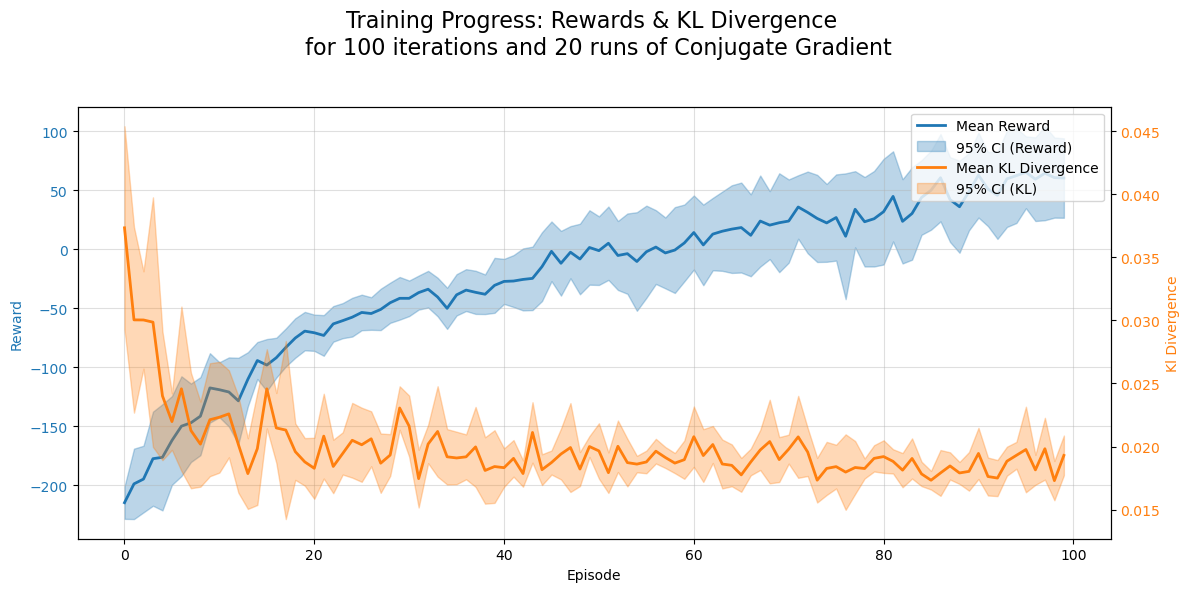

In [25]:
mean_rewards = np.mean(rewards_all, axis=0)
sem_rewards  = sem(rewards_all, axis=0)           # shape (n_episodes,)
ci_rewards   = 1.96 * sem_rewards                    # ~95% CI

# JS Divergence
mean_js = np.mean(kl_all, axis=0)
sem_js  = sem(kl_all, axis=0)
ci_js   = 1.96 * sem_js

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Rewards
episodes = np.arange(mean_rewards.shape[0])
color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, mean_rewards, color=color, lw=2, label='Mean Reward')
ax1.fill_between(episodes,
                 mean_rewards - ci_rewards,
                 mean_rewards + ci_rewards,
                 color=color, alpha=0.3,
                 label='95% CI (Reward)')
ax1.tick_params(axis='y', labelcolor=color)

# Secondary y-axis: JS Divergence
ax2 = ax1.twinx()
episodes_js = np.arange(mean_js.shape[0])
color = 'tab:orange'
ax2.set_ylabel('Kl Divergence', color=color)
ax2.plot(episodes_js, mean_js,  color=color, lw=2, label='Mean KL Divergence')
ax2.fill_between(episodes_js,
                 mean_js - ci_js,
                 mean_js + ci_js,
                 color=color, alpha=0.3,
                 label='95% CI (KL)')
ax2.tick_params(axis='y', labelcolor=color)

# Title, legends, grid
fig.suptitle(f'Training Progress: Rewards & KL Divergence \n for {iterations} iterations and {num_runs} runs of Conjugate Gradient', fontsize=16)
ax1.grid(alpha=0.4)
# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


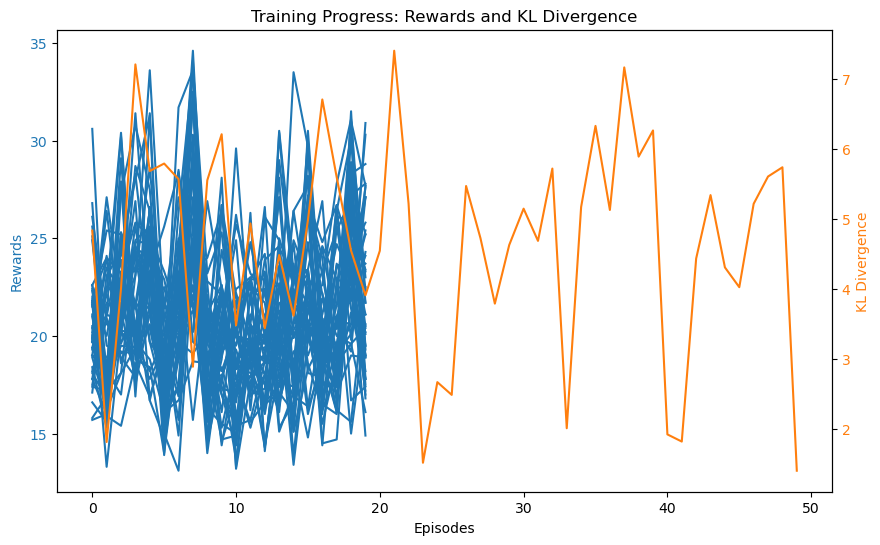

In [ ]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot rewards history on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Rewards', color=color)
ax1.plot(rewards_all, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()

# Plot KL history on secondary y-axis
color = 'tab:orange'
ax2.set_ylabel('KL Divergence', color=color)
# Filter out None values from KL_history
kl_values = [x for x in KL_history if x is not None]
if kl_values:  # Only plot if there are non-None values
    ax2.plot(range(len(kl_values)), kl_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Progress: Rewards and KL Divergence')
plt.show()

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_16028\2305145838.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


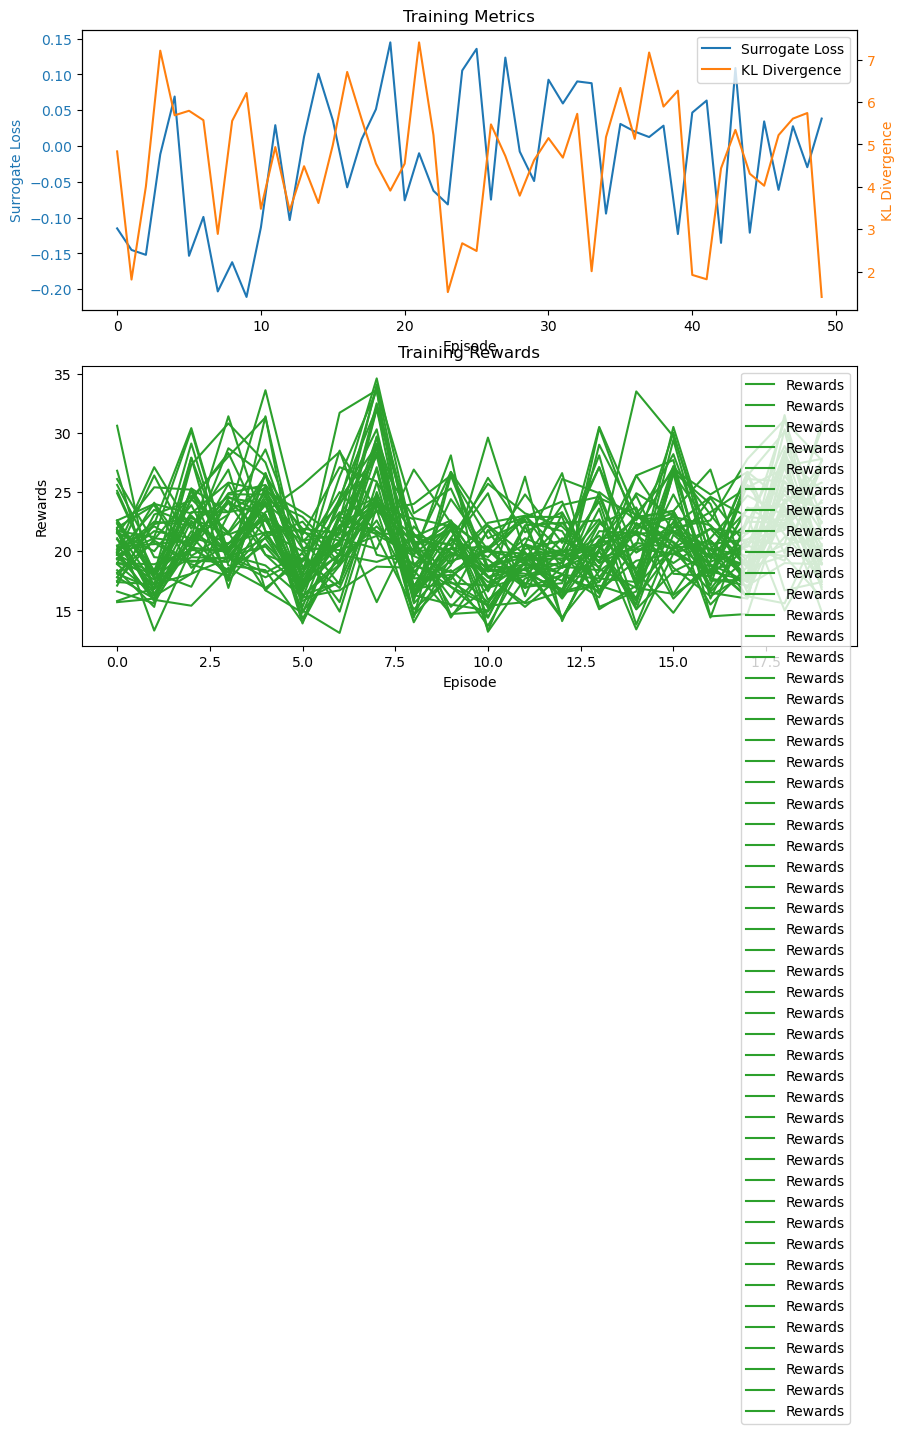

In [ ]:
# Create two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 8))

# First subplot: Surrogate Loss and KL Divergence
ax1.set_xlabel('Episode')
ax1.set_ylabel('Surrogate Loss', color='tab:blue')
ax1.plot(surrogate_loss_history, color='tab:blue', label='Surrogate Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for KL divergence
ax2 = ax1.twinx()
ax2.set_ylabel('KL Divergence', color='tab:orange')
ax2.plot(KL_history, color='tab:orange', label='KL Divergence')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legend for first subplot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Second subplot: Rewards
ax3.set_xlabel('Episode')
ax3.set_ylabel('Rewards')
ax3.plot(rewards_all, color='tab:green', label='Rewards')
ax3.legend(loc='upper right')

# Add titles
ax1.set_title('Training Metrics')
ax3.set_title('Training Rewards')

plt.tight_layout()
plt.show()